# GRAD504 - Fall 2025
# Team project: ML classification methods for financial applications
## Modeling and evaluation code for final submission
### Armando Cova

In [1]:
import os
# Manually set the number of CPU cores to use
# Replace 4 with the number of cores you want to use
os.environ["LOKY_MAX_CPU_COUNT"] = "8"

### Import modeling and visualization Libraries
import numpy as np
import pandas as pd
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 120)  # Set maximum column width

import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold      # for stratified K-fold on train
)

from sklearn.metrics import (
    recall_score,
    precision_score,
    accuracy_score,
    f1_score,
    roc_auc_score,
    average_precision_score,   # PR-AUC
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from sklearn.ensemble import (
    RandomForestClassifier,
)

from sklearn.linear_model import LogisticRegression

# SMOTE + Pipeline from imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading dataset
file_name = 'creditcard.csv'
data = pd.read_csv(file_name)

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
X_data = data.iloc[:,1:29]
y_data = data.iloc[:, -1]

In [6]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 28 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

In [7]:
### 60/20/20 split with stratification to handle class imbalance
X_temp, X_test, y_temp, y_test = train_test_split(
    X_data,
    y_data,
    test_size=0.2,          # 20% for final test
    stratify=y_data,             # preserve class proportions
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,         # 25% of 80% = 20% of total for validation
    stratify=y_temp,
    random_state=42
)

# Inner K-fold CV on TRAIN ONLY (60%)
cv_inner = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)



In [11]:
### Define classification models and parameter grids for searches (with SMOTE toggle)

# Helper to build a pipeline: SMOTE -> classifier
def make_smote_pipeline(clf):
    return Pipeline(steps=[
        ('smote', SMOTE(random_state=42)),  # may be overridden to None in param_grid
        ('clf', clf)
    ])

# Define classifiers wrapped in pipelines
classifiers = {
    'RandomForest': make_smote_pipeline(
        RandomForestClassifier(
            random_state=42,
            n_jobs=-1      # use all allowed cores inside each RF
        )
    )
}

# List of SMOTE options to explore:
# - None: no oversampling
# - SMOTE(...): apply SMOTE inside the pipeline during training folds
base_smote_list = [None, SMOTE(random_state=42)]

# Define parameter grids
param_grids = {
    'RandomForest': {
        'smote': base_smote_list,
        'clf__n_estimators': [200, 500],
        'clf__max_depth': [None, 10, 20],
        'clf__min_samples_leaf': [1, 5],
        'clf__class_weight': [None, 'balanced']
    }
}



Starting grid search with scoring = recall


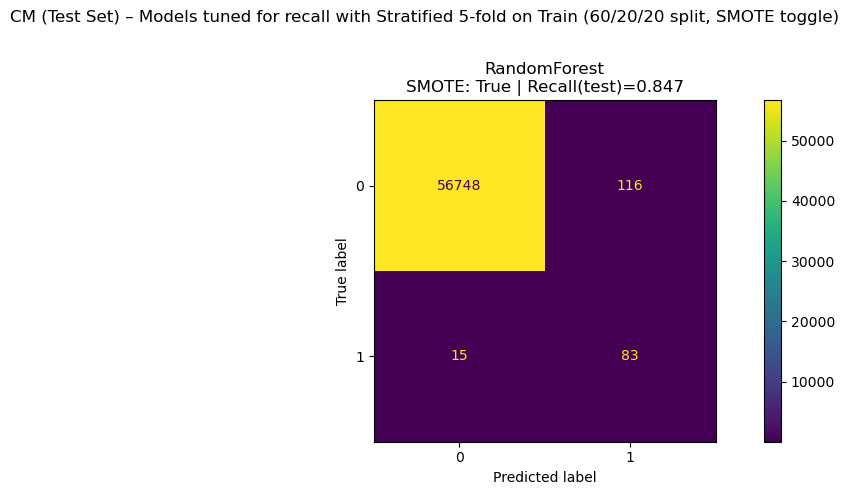

In [14]:

### Train and validate classifiers using 60/20/20 + Stratified K-fold on train + SMOTE toggle
scoring_metrics = ['recall']
hyper_param_search_method = 'GridSearchCV'

grid_search_results_df_dict = {}   # per scoring metric
best_models_dict = {}              # store best models per (scoring_metric, classifier)
roc_pr_curves = {}                 # store curves to plot later


for scoring_metric in scoring_metrics:
    print(f"Starting grid search with scoring = {scoring_metric}")
    fig, axes = plt.subplots(nrows=len(classifiers), ncols=1, figsize=(10, 5*len(classifiers)))
    
    # If there's only one classifier, axes won't be an array, so we need to handle that case
    if len(classifiers) == 1:
        axes = [axes]  # Convert single Axes to a list with one element

    fig.suptitle(
        f'CM (Test Set) – Models tuned for {scoring_metric} '
        f'with Stratified 5-fold on Train (60/20/20 split, SMOTE toggle)\n',
        x=0.5
    )
    results = []

    for idx, (name, pipeline_est) in enumerate(classifiers.items()):
        # Build the appropriate search object
        match hyper_param_search_method:
            case "GridSearchCV":
                search = GridSearchCV(
                    estimator=pipeline_est,
                    param_grid=param_grids[name],
                    scoring=scoring_metric,
                    cv=cv_inner,      # stratified K-fold on TRAIN
                    n_jobs=-1
                )
            case _:
                print("Unknown hyperparam search method")
                continue

        # Fit on TRAIN ONLY (60%) with inner stratified K-fold + SMOTE inside pipeline
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        best_params = search.best_params_

        # Keep best model for later analysis / plotting
        best_models_dict[(scoring_metric, name)] = best_model

        # Convenience flag: whether SMOTE was used in the best setting
        use_smote = best_params.get('smote', None) is not None

        # ---------- PROBABILITIES for AUC/PR-AUC (VAL + TEST) ----------
        # 
        if hasattr(best_model, "predict_proba"):
            y_val_scores  = best_model.predict_proba(X_val)[:, 1]
            y_test_scores = best_model.predict_proba(X_test)[:, 1]
        elif hasattr(best_model, "decision_function"):
            y_val_scores  = best_model.decision_function(X_val)
            y_test_scores = best_model.decision_function(X_test)
        else:
            y_val_scores  = None
            y_test_scores = None
            
        # ---- Evaluation on VALIDATION set (20%) ----
        y_val_pred = best_model.predict(X_val)
        val_accuracy  = accuracy_score(y_val, y_val_pred)
        val_recall    = recall_score(y_val, y_val_pred)
        val_precision = precision_score(y_val, y_val_pred)
        val_f1        = f1_score(y_val, y_val_pred)

        # VAL ROC-AUC and PR-AUC (if we have scores)
        if y_val_scores is not None:
            val_roc_auc = roc_auc_score(y_val, y_val_scores)
            val_pr_auc  = average_precision_score(y_val, y_val_scores)
        else:
            val_roc_auc = np.nan
            val_pr_auc  = np.nan
        
        
        # ---- Final evaluation on TEST set (20%) ----
        y_test_pred = best_model.predict(X_test)
        test_accuracy  = accuracy_score(y_test, y_test_pred)
        test_recall    = recall_score(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred)
        test_f1        = f1_score(y_test, y_test_pred)

        # TEST ROC-AUC and PR-AUC
        if y_test_scores is not None:
            test_roc_auc = roc_auc_score(y_test, y_test_scores)
            test_pr_auc  = average_precision_score(y_test, y_test_scores)
        else:
            test_roc_auc = np.nan
            test_pr_auc  = np.nan

        # Optionally store curves for later plotting
        if y_test_scores is not None:
            fpr, tpr, _ = roc_curve(y_test, y_test_scores)
            precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_test_scores)
            roc_pr_curves[(scoring_metric, name)] = {
                "fpr": fpr, "tpr": tpr,
                "precision": precision_curve, "recall": recall_curve
            }

        
        # Confusion matrix on TEST set
        cm = confusion_matrix(y_test, y_test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=axes[idx])
        axes[idx].set_title(
            f"{name}\nSMOTE: {use_smote} | Recall(test)={test_recall:.3f}"
        )

        # Store BOTH validation and test metrics + whether SMOTE was used
        results.append({
            'Scoring Metric': scoring_metric,
            'Classifier': name,
            'Use_SMOTE': use_smote,
            'Val Accuracy': val_accuracy,
            'Val Recall': val_recall,
            'Val Precision': val_precision,
            'Val F1 Score': val_f1,
            'Val ROC-AUC': val_roc_auc,      
            'Val PR-AUC': val_pr_auc,        
            'Test Accuracy': test_accuracy,
            'Test Recall': test_recall,
            'Test Precision': test_precision,
            'Test F1 Score': test_f1,
            'Test ROC-AUC': test_roc_auc,   
            'Test PR-AUC': test_pr_auc,     
            'Best Params': best_params
        })


    plt.tight_layout()
    # plt.show()
    grid_search_results_df = pd.DataFrame(results)
    grid_search_results_df.set_index('Classifier', inplace=True)
    grid_search_results_df_dict[scoring_metric] = grid_search_results_df


In [15]:
# Save results offline for processing and visualization
import joblib

artifacts = {
    # results & models
    "grid_search_results_df_dict": grid_search_results_df_dict,
    "best_models_dict": best_models_dict,
    "roc_pr_curves": roc_pr_curves,  

    # data splits
    "X_train": X_train,
    "X_val": X_val,
    "X_test": X_test,
    "y_train": y_train,
    "y_val": y_val,
    "y_test": y_test,

    # model setup
    "classifiers": classifiers,
    "param_grids": param_grids,
    "cv_inner": cv_inner,
}

joblib.dump(artifacts, "model_selection_artifacts_RF_recall.pkl")
print("Saved to model_selection_artifacts_RF_recall.pkl")


Saved to model_selection_artifacts_RF_recall.pkl
